In [1]:
import math
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import seaborn as sns
import numpy as np


In [2]:
def get_aupr(pre, rec):
    pr_value = 0.0
    for ii in range(len(rec[:-1])):
        x_r, x_l = rec[ii], rec[ii+1]
        y_t, y_b = pre[ii], pre[ii+1]
        tempo = abs(x_r - x_l) * (y_t + y_b) * 0.5
        pr_value += tempo
    return pr_value

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

def scores_regression(y_true, y_pred):
    # Round predictions to nearest class (0–4)
    y_pred_class = np.clip(np.round(y_pred).astype(int), 0, 4)

    # Core regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Accuracy as classification
    acc = accuracy_score(y_true, y_pred_class)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_class, labels=[0, 1, 2, 3, 4])

    return [mse, rmse, mae, r2, acc], cm

# LLM data

In [3]:
def construct_feature_matrices2(lociembeddings_path, rbpembeddings_path, mode='train'):
    """
    Constructs feature matrices for machine learning from ESM-2 embeddings.

    Parameters:
    - lociembeddings_path: Path to loci embeddings CSV
    - rbpembeddings_path: Path to RBP embeddings CSV
    - mode: 'train' or 'test' (default is 'train')

    Returns:
    - If train: features_esm2, labels, groups_loci, groups_phage
    - If test: features_esm2, groups_loci
    """
    RBP_embeddings = pd.read_csv(rbpembeddings_path)
    loci_embeddings = pd.read_csv(lociembeddings_path)

    if mode == 'train':
        interactions = pd.read_csv("./esm-features_ordinal/ordinal_interaction_matrix.csv",  sep=";", index_col=0)

        # Get valid phages and loci from interactions
        valid_phages = interactions.columns.tolist()
        valid_loci = interactions.index.tolist()

        # Filter embeddings to only use valid entries
        RBP_embeddings = RBP_embeddings[RBP_embeddings['phage_ID'].str.replace('.fna', '').isin(valid_phages)]
        loci_embeddings = loci_embeddings[loci_embeddings['accession'].isin(valid_loci)]
        print(len(RBP_embeddings), len(loci_embeddings))

    # Construct multi-RBP representations
    multi_embeddings = []
    names = []
    for phage_id in sorted(set(RBP_embeddings['phage_ID'])):
        phage_key = phage_id.split('.')[0]
        if mode == 'test' or phage_key in valid_phages:
            rbp_embeddings = RBP_embeddings.iloc[:, 2:][RBP_embeddings['phage_ID'] == phage_id]
            multi_embedding = np.mean(np.asarray(rbp_embeddings), axis=0)
            names.append(phage_id)
            multi_embeddings.append(multi_embedding)

    multiRBP_embeddings = pd.concat([pd.DataFrame({'phage_ID': names}), pd.DataFrame(multi_embeddings)], axis=1)

    # Build features
    features_lan = []
    labels = []
    groups_loci = []
    groups_phage = []

    for i, accession in enumerate(loci_embeddings['accession']):
        for j, phage_id in enumerate(multiRBP_embeddings['phage_ID']):
            phage_key = phage_id.split('.')[0]
            if mode == 'train':
                if accession in interactions.index and phage_key in interactions.columns:
                    interaction = interactions.loc[accession][phage_key]
                    if not math.isnan(interaction):
                        combined = pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]])
                        features_lan.append(combined.to_numpy(dtype=np.float32))  # Ensures numeric array
                        labels.append(interaction)
                        groups_loci.append(i)
                        groups_phage.append(j)
            elif mode == 'test':
                combined = pd.concat([loci_embeddings.iloc[i, 1:], multiRBP_embeddings.iloc[j, 1:]])
                features_lan.append(combined.to_numpy(dtype=np.float32))
                groups_loci.append(i)
                groups_phage.append(j)

    features_lan = np.asarray(features_lan)
    print("Dimensions match?", features_lan.shape[1] == (loci_embeddings.shape[1] + multiRBP_embeddings.shape[1] - 2))
    
    features_lan = np.array(features_lan, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    if mode == 'train':
        return features_lan, labels, groups_loci, groups_phage
    elif mode == 'test':
        return features_lan, groups_loci
    
general_output_path = "./esm-features_ordinal"

loci_embeddings_path = "./esm-features_ordinal/esm2_embeddings_lociJonas.csv"
rbp_embeddings_path ="./esm-features_ordinal/esm2_embeddings_rbpJonas2.csv"

features_esm2, labels, groups_loci, groups_phage = construct_feature_matrices2(loci_embeddings_path, rbp_embeddings_path)

462 402
Dimensions match? True


In [4]:
# Tune hyperparameters on the entire dataset
param_grid = {
    'n_estimators': [100, 150],      # Number of trees in the forest
    'max_depth': [12, 10],           # Max depth of each tree
    'min_samples_leaf': [8, 10],     # Minimum samples required at each leaf node
}

base_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(base_model, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(features_esm2, labels)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 150}


In [4]:
# Stratify on binned labels
best_params = {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 150}

labels = np.asarray(labels)
features_esm2 = np.asarray(features_esm2)
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_labels = binner.fit_transform(labels.reshape(-1, 1)).astype(int).ravel()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_all = []
conf_matrices = []
models = []

pbar = tqdm(total=kf.get_n_splits(features_esm2, stratify_labels))

for train_idx, test_idx in kf.split(features_esm2, stratify_labels):
    X_train, X_test = features_esm2[train_idx], features_esm2[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    best_model = RandomForestRegressor(**best_params, n_jobs=-1, random_state=42)
    best_model.fit(X_train, y_train)
    models.append(best_model)

    y_pred = best_model.predict(X_test)

    try:
        fold_scores, cm = scores_regression(y_test, y_pred)
    except Exception as e:
        print(f"Error on fold: {e}")
        fold_scores = [np.nan] * 3
        cm = np.zeros((5, 5), dtype=int)

    results_all.append(fold_scores)
    conf_matrices.append(cm)
    pbar.update(1)

pbar.close()

100%|██████████| 5/5 [59:53<00:00, 718.71s/it]


In [5]:
metric_names = ["MSE", "RMSE", "MAE", "R2", "ACC"]

results_array = np.array(results_all)
results_df = pd.DataFrame(results_array, columns=metric_names)
results_df.index = [f"Fold {i+1}" for i in range(len(results_all))]

# Print fold-wise results
print("=== Fold-wise Performance ===")
display(results_df)

# Summary stats+

print("\n=== Mean ===")
display(results_df.mean())

print("\n=== Std Dev ===")
display(results_df.std())


=== Fold-wise Performance ===


,MSE,RMSE,MAE,R2,ACC
Fold 1,0.598884,0.773876,0.458686,0.410524,0.705228
Fold 2,0.562369,0.749913,0.434726,0.447089,0.728969
Fold 3,0.608186,0.779863,0.460909,0.402043,0.709757
Fold 4,0.595895,0.771942,0.459926,0.414127,0.705640
Fold 5,0.592721,0.769884,0.451563,0.416654,0.708619



=== Mean ===


MSE     0.591611
RMSE    0.769095
MAE     0.453162
R2      0.418087
ACC     0.711643
dtype: float64


=== Std Dev ===


MSE     0.017337
RMSE    0.011352
MAE     0.010940
R2      0.017128
ACC     0.009875
dtype: float64

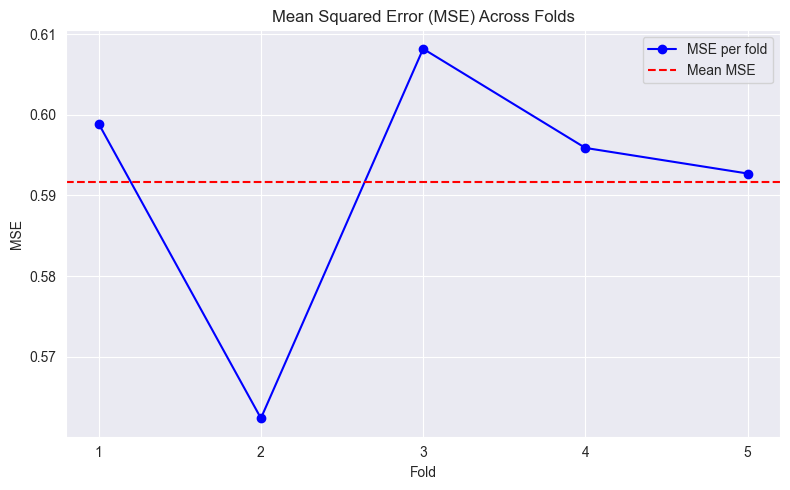

In [6]:
import matplotlib.pyplot as plt

# Assuming results_array[:, 0] contains MSE values per fold
mse_values = results_array[:, 0]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE per fold')
plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.title('Mean Squared Error (MSE) Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(range(1, len(mse_values) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

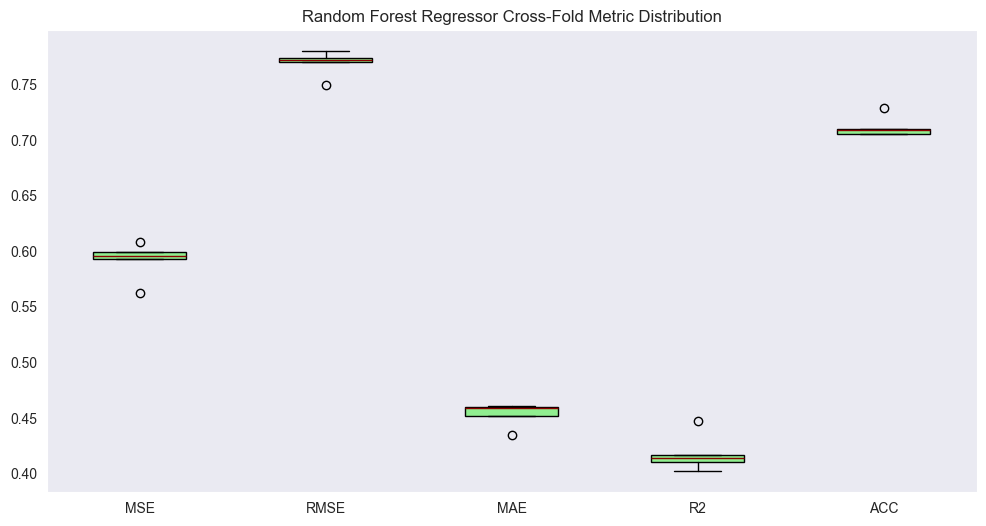

In [7]:
plt.figure(figsize=(12, 6))
plt.boxplot(results_array, tick_labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='black'))
plt.title("Random Forest Regressor Cross-Fold Metric Distribution")
plt.grid()
plt.show()


[[23893  4095   619    19     0]
 [ 1116  1328   462    21     0]
 [  484  1102   625    36     1]
 [  130   597   549    71     1]
 [   74   404   635   161    11]]


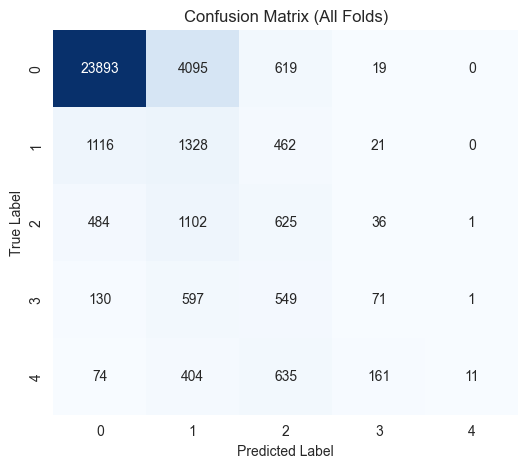

In [8]:

# Step 1: Sum all confusion matrices
avg_cm = np.sum(conf_matrices, axis=0)
print(avg_cm)

# Remove normalization step to keep raw counts
# avg_cm = avg_cm.astype('float') / avg_cm.sum(axis=1, keepdims=True)

# Step 2: Plot the averaged confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (All Folds)")
plt.show()

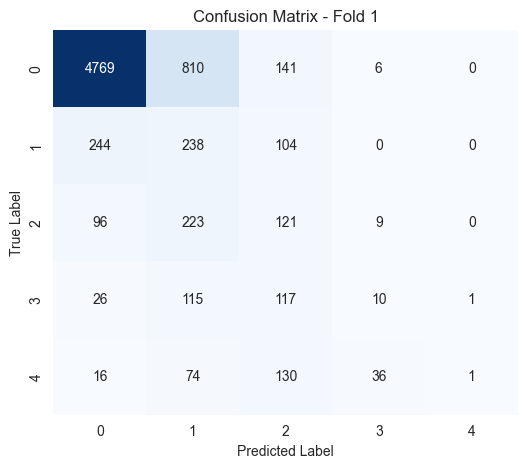

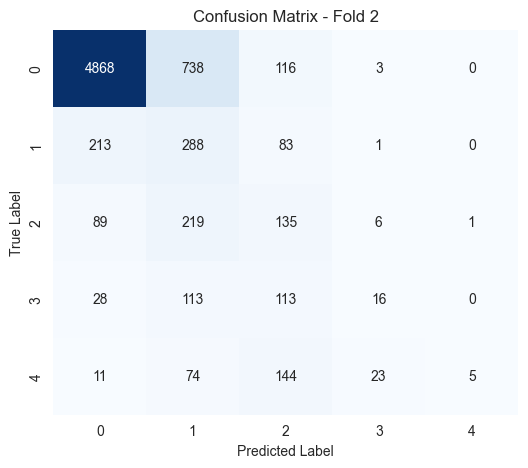

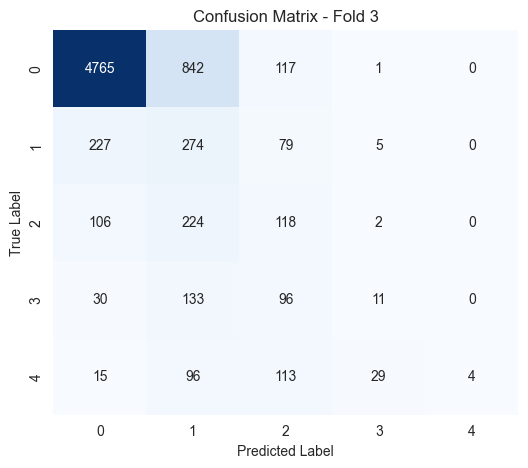

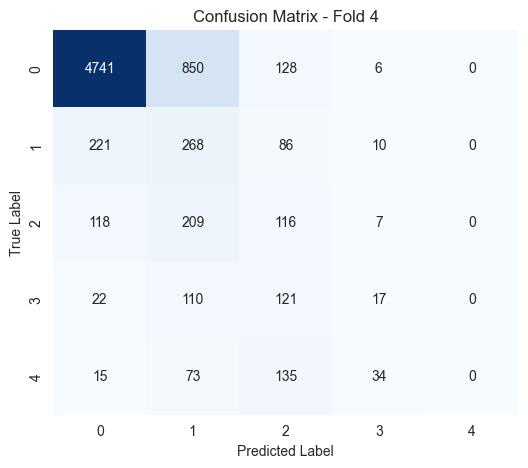

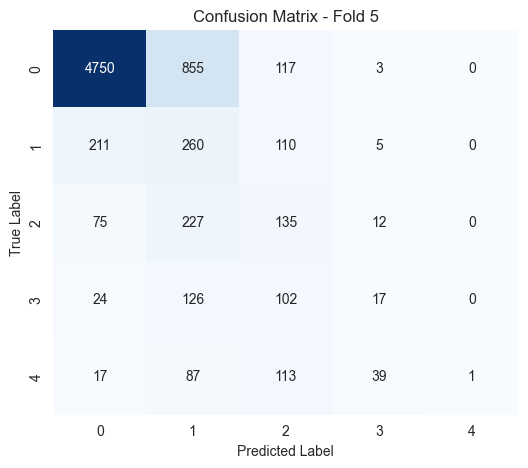

In [9]:

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {i+1}")
    plt.show()

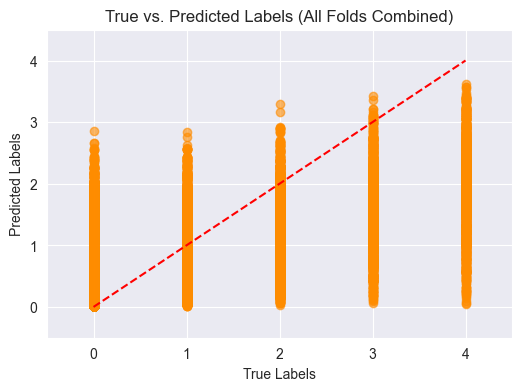

In [10]:
# Collect predictions and true labels from all folds
all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(features_esm2, labels):
    X_test = features_esm2[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Convert to NumPy arrays for plotting
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Plotting combined true vs. predicted labels
plt.figure(figsize=(6, 4))
plt.scatter(all_y_true, all_y_pred, alpha=0.6, color='darkorange')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("True vs. Predicted Labels (All Folds Combined)")
plt.plot([0, 4], [0, 4], 'r--')  # identity line
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()

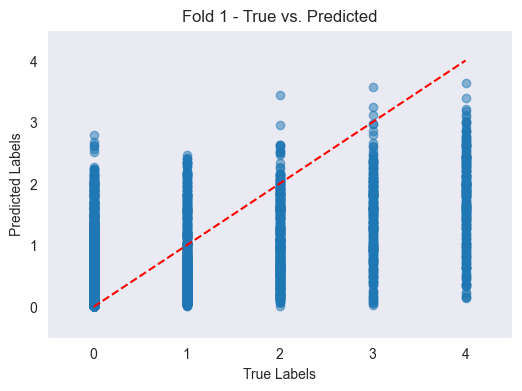

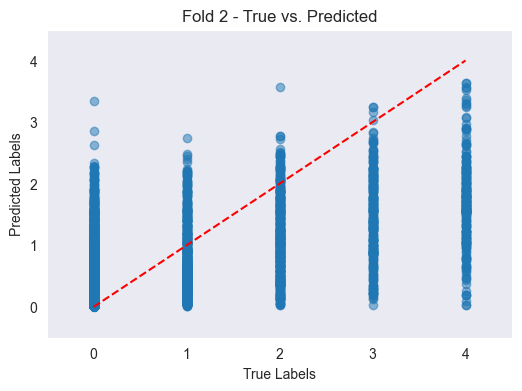

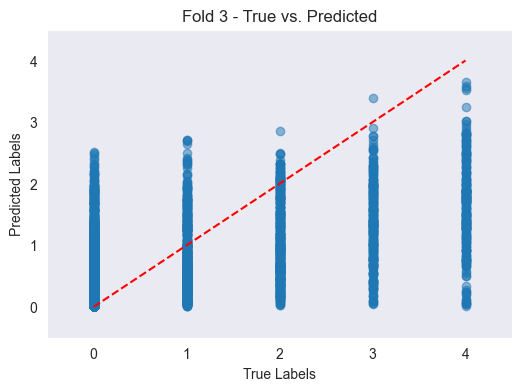

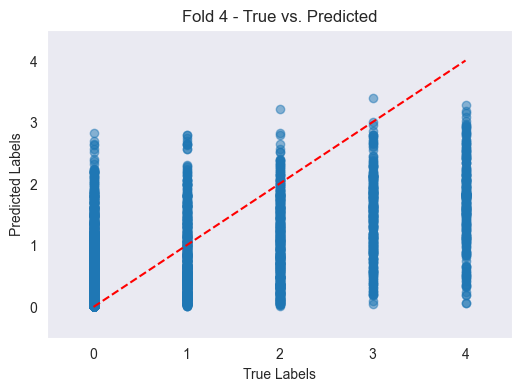

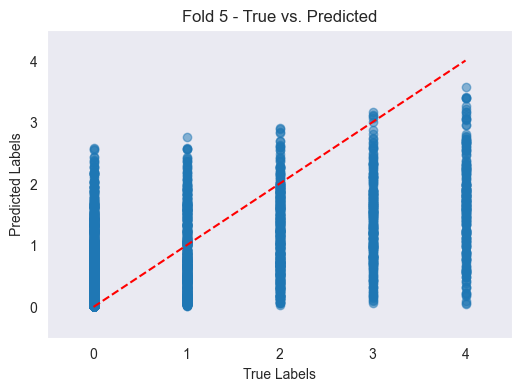

In [11]:
for i, (train_idx, test_idx) in enumerate(kf.split(features_esm2, labels)):
    X_test = features_esm2[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test) 

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title(f"Fold {i+1} - True vs. Predicted")
    plt.grid()
    plt.plot([0, 4], [0, 4], 'r--')
    plt.xlim(-0.5, 4.5)
    plt.ylim(-0.5, 4.5)
    plt.show()


In [12]:

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 120],              # Number of boosting rounds
    'max_depth': [8, 10],                       # Max depth of trees
    'learning_rate': [0.3, 0.1],            # Step size shrinkage
}


xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=7,
    scoring='neg_mean_squared_error'
)
grid_search.fit(features_esm2, labels)

best_params = grid_search.best_params_
print("Best XGBoost Hyperparameters:", best_params)


Best XGBoost Hyperparameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}


In [13]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
import numpy as np
from tqdm import tqdm

# Prepare binned labels for stratification
labels = np.asarray(labels)
features_esm2 = np.asarray(features_esm2)
binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
stratify_labels = binner.fit_transform(labels.reshape(-1, 1)).astype(int).ravel()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_all = []
models = []
conf_matrices = []

pbar = tqdm(total=kf.get_n_splits(features_esm2, stratify_labels))

for train_index, test_index in kf.split(features_esm2, stratify_labels):
    X_train, X_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **best_params  # use tuned params
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    models.append(model)

    try:
        fold_scores, cm = scores_regression(y_test, y_pred)
    except Exception as e:
        print(f"Error on fold: {e}")
        fold_scores = [np.nan] * 5
        cm = np.zeros((5, 5), dtype=int)

    results_all.append(fold_scores)
    conf_matrices.append(cm)
    pbar.update(1)

pbar.close()

100%|██████████| 5/5 [04:59<00:00, 59.91s/it]


In [16]:


metric_names = ["MSE", "RMSE", "MAE", "R2", "ACC"]

results_array = np.array(results_all)
results_df = pd.DataFrame(results_array, columns=metric_names)
results_df.index = [f"Fold {i+1}" for i in range(len(results_all))]

print("=== Fold-wise Performance ===")
print(results_df.to_string())

print("\n=== Mean ===")
print(results_df.mean().to_string())

print("\n=== Std Dev ===")
print(results_df.std().to_string())



=== Fold-wise Performance ===
             MSE      RMSE       MAE        R2       ACC
Fold 1  0.555475  0.745302  0.428004  0.453251  0.721147
Fold 2  0.525359  0.724817  0.409456  0.483477  0.742281
Fold 3  0.564803  0.751534  0.430171  0.444696  0.731028
Fold 4  0.550411  0.741897  0.426159  0.458847  0.727734
Fold 5  0.543074  0.736935  0.417913  0.465516  0.734559

=== Mean ===
MSE     0.547824
RMSE    0.740097
MAE     0.422341
R2      0.461157
ACC     0.731350

=== Std Dev ===
MSE     0.014839
RMSE    0.010058
MAE     0.008567
R2      0.014629
ACC     0.007859


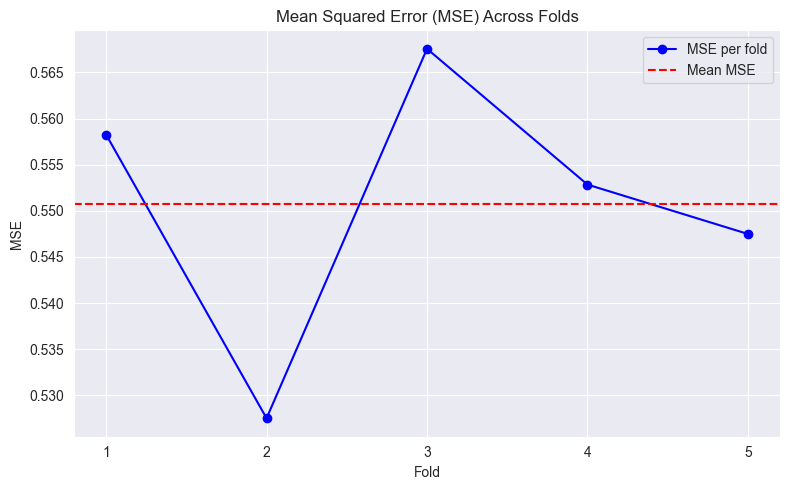

In [7]:
import matplotlib.pyplot as plt

# Assuming results_array[:, 0] contains MSE values per fold
mse_values = results_array[:, 0]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE per fold')
plt.axhline(np.mean(mse_values), color='red', linestyle='--', label='Mean MSE')
plt.title('Mean Squared Error (MSE) Across Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.xticks(range(1, len(mse_values) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

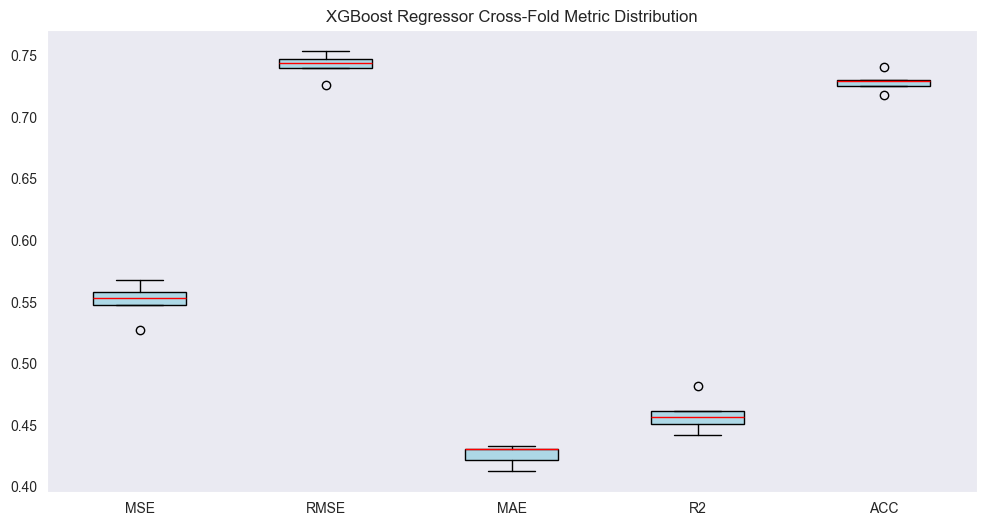

In [8]:

# Boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(results_df.values, tick_labels=metric_names, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))
plt.title("XGBoost Regressor Cross-Fold Metric Distribution")
plt.grid()
plt.show()


[[24428  3522   623    53     0]
 [ 1165  1256   463    43     0]
 [  501   993   664    87     3]
 [  118   535   540   142    13]
 [   74   341   523   290    57]]


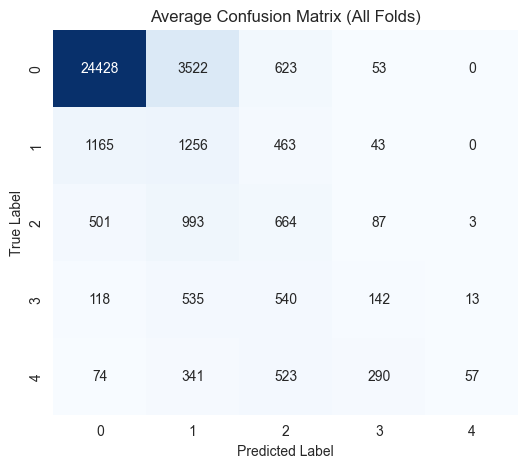

In [9]:

# Step 1: Sum all confusion matrices
avg_cm = np.sum(conf_matrices, axis=0)

print(avg_cm)
# Remove normalization step to keep raw counts
# avg_cm = avg_cm.astype('float') / avg_cm.sum(axis=1, keepdims=True)

# Step 2: Plot the averaged confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (All Folds)")
plt.show()

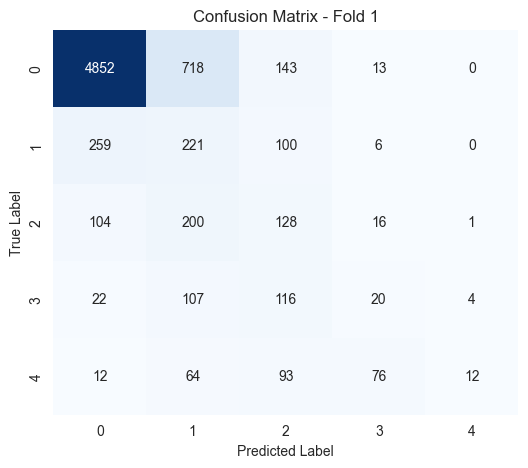

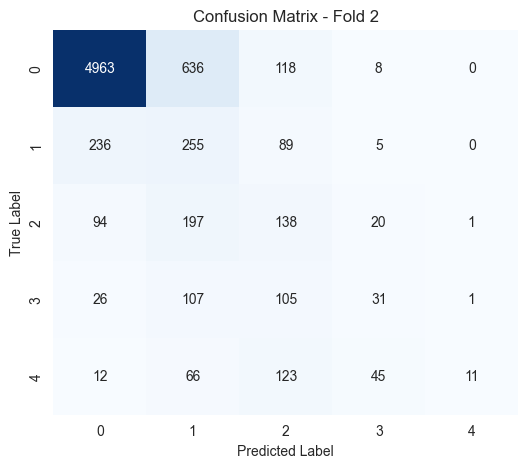

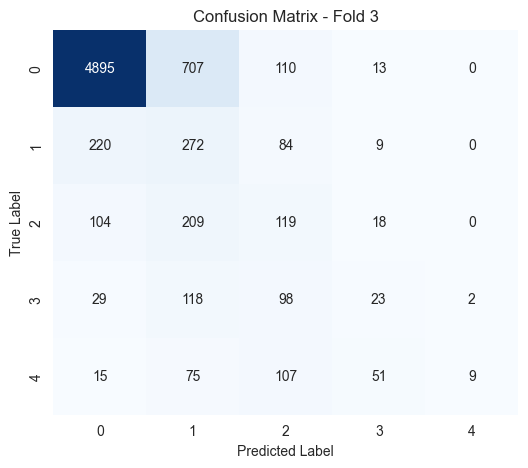

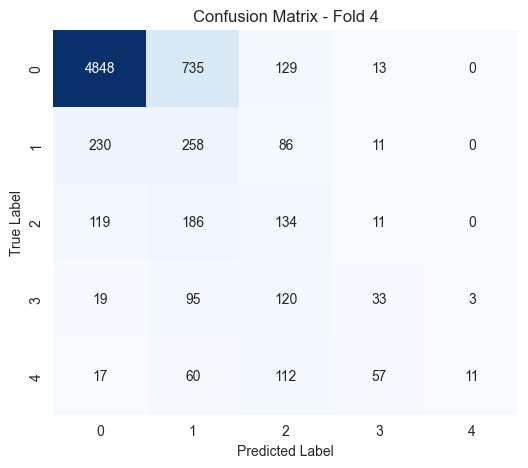

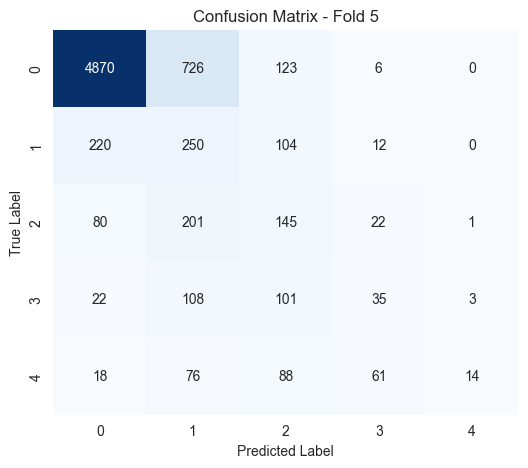

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {i+1}")
    plt.show()

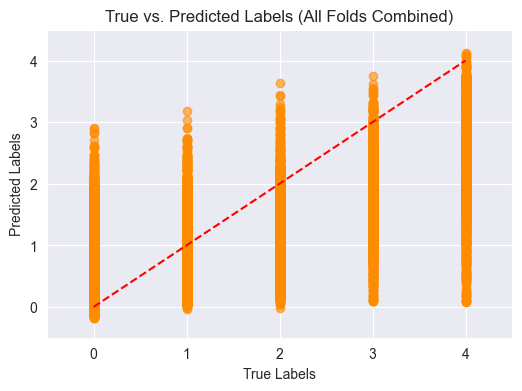

In [11]:
# Collect predictions and true labels from all folds
all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(features_esm2, labels):
    X_test = features_esm2[test_idx]
    y_test = labels[test_idx]
    y_pred = models[i].predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Convert to NumPy arrays for plotting
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Plotting combined true vs. predicted labels
plt.figure(figsize=(6, 4))
plt.scatter(all_y_true, all_y_pred, alpha=0.6, color='darkorange')
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("True vs. Predicted Labels (All Folds Combined)")
plt.plot([0, 4], [0, 4], 'r--')  # identity line
plt.xlim(-0.5, 4.5)
plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()
